# Credit Card Approval Prediction

<a id="2"></a>
## Data Content
There're two tables could be merged by ID:


**application_record.csv**	:
- ID	Client: number
- CODE_GENDER:	Gender
- FLAG_OWN_CAR:	Is there a car
- FLAG_OWN_REALTY:	Is there a property
- CNT_CHILDREN:	Number of children
- AMT_INCOME_TOTAL:	Annual income
- NAME_INCOME_TYPE:	Income category
- NAME_EDUCATION_TYPE:	Education level
- NAME_FAMILY_STATUS:	Marital status
- NAME_HOUSING_TYPE:	Way of living
- DAYS_BIRTH:	Birthday	Count backwards from current day (0), -1 means yesterday
- DAYS_EMPLOYED:	Start date of employment. Count backwards from current day(0). If positive, it means the person currently unemployed.
- FLAG_MOBIL:	Is there a mobile phone
- FLAG_WORK_PHONE:	Is there a work phone
- FLAG_PHONE:	Is there a phone
- FLAG_EMAIL:	Is there an email
- OCCUPATION_TYPE:	Occupation
- CNT_FAM_MEMBERS:	Family size


**credit_record.csv** :
- ID:	Client number
- MONTHS_BALANCE:	Record month. The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
- STATUS	Status	0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month

## What topics are covered in this project?
* Preprocessing: missing value, train-test split and normalization
* Feature Engineering
* Feature Importance and Selection
* Modelling: Ensemble Model :LightGBM-Gradient Boosting
* LightGBM and Gradient Boosting Hyperparameter Tuning and Optimization
* Ensemble Methods
* Handling Class Imbalance
* Model Training and Evaluation

## Content
1. [Python Libraries](#1)
1. [Data Loading and Initial Exploration](#2)
1. [Handling Duplicates and Missing Values](#3)
1. [Feature Analysis and Manupulation](#4)
1. [Credit Scoring Calculation](#5)
1. [Merging and Preprocessing Datasets](#6)
1. [Data Visualization](#7)
1. [Data Splitting and Preprocessing](#8)
1. [Model Training and Evaluation](#9)
1. [Feature Importance and Selection](#10)
1. [Hyperparameter Tuning and Optimization](#11)
1. [Ensemble Methods](#12)
1. [Handling Class Imbalance](#13)
1. [Final Model Training and Evaluation](#14)

<a id="1"></a>
## 1. Python Libraries

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Typing and Pretty Printing
from typing import List, Dict, Any
from pprint import pprint

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

# Model Selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

# Pipelines and Column Transformation
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Machine Learning Models
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

# Decision Trees
from sklearn.tree import DecisionTreeRegressor, export_text

# Model Evaluation
from sklearn.metrics import make_scorer, accuracy_score, classification_report, f1_score, roc_auc_score, precision_recall_curve, average_precision_score, matthews_corrcoef, balanced_accuracy_score, precision_score, recall_score

# Class Weight Computation
from sklearn.utils.class_weight import compute_class_weight

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# Model Calibration
from sklearn.calibration import CalibratedClassifierCV

# Oversampling Techniques
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


<a id="2"></a>
## 2. Data Loading and Initial Exploration

In [2]:
data_app = pd.read_csv('application_record.csv')

In [3]:
data_cre = pd.read_csv('credit_record.csv')

In [4]:
data_app.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [5]:
data_cre.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [6]:
data_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [7]:
data_cre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


<a id="3"></a>
## 3. Handling Duplicates and Missing Values

In [8]:
data_app.ID.nunique()

438510

In [9]:
duplicate_ids = data_app[data_app.duplicated(subset=['ID'], keep=False)].sort_values('ID')
duplicate_ids

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
426818,7022197,M,Y,Y,3,135000.0,Working,Secondary / secondary special,Married,House / apartment,-11945,-735,1,0,0,1,Laborers,5.0
425023,7022197,F,N,Y,0,450000.0,Commercial associate,Higher education,Separated,House / apartment,-19813,-1799,1,0,0,1,NaN,1.0
431545,7022327,F,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-14771,-5298,1,0,0,0,High skill tech staff,1.0
431911,7022327,M,Y,Y,0,256500.0,Commercial associate,Higher education,Married,House / apartment,-21503,-1674,1,0,0,1,Core staff,2.0
425486,7023108,M,Y,Y,1,67500.0,Working,Secondary / secondary special,Married,House / apartment,-15156,-1696,1,1,0,0,Core staff,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426563,7836711,F,N,Y,2,292500.0,Working,Higher education,Married,House / apartment,-13747,-4386,1,0,1,0,Accountants,4.0
421464,7836971,M,Y,N,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13771,-5520,1,0,0,0,NaN,3.0
428620,7836971,F,N,Y,0,103500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-13383,-2798,1,0,1,0,Sales staff,2.0
422068,7838075,M,N,Y,0,337500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-18198,-1275,1,0,0,1,Drivers,2.0


##### Understanding duplication

In [10]:
# Grouping duplicate IDs
grouped_duplicates = duplicate_ids.groupby('ID')

# Finding columns that differ
differences = {}

for client_id, group in grouped_duplicates:
    # Find the columns that differ for each group
    diff = group.loc[:, group.nunique() > 1]
    differences[client_id] = diff

# Printing the differences on the screen
for client_id, diff in differences.items():
    print(f"ID: {client_id}")
    print(diff)
    print("\n")

ID: 7022197
       CODE_GENDER FLAG_OWN_CAR  CNT_CHILDREN  AMT_INCOME_TOTAL  \
426818           M            Y             3          135000.0   
425023           F            N             0          450000.0   

            NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
426818               Working  Secondary / secondary special   
425023  Commercial associate               Higher education   

       NAME_FAMILY_STATUS  DAYS_BIRTH  DAYS_EMPLOYED  CNT_FAM_MEMBERS  
426818            Married      -11945           -735              5.0  
425023          Separated      -19813          -1799              1.0  


ID: 7022327
       CODE_GENDER FLAG_OWN_CAR  AMT_INCOME_TOTAL  \
431545           F            N          135000.0   
431911           M            Y          256500.0   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  DAYS_BIRTH  \
431545  Secondary / secondary special  Single / not married      -14771   
431911               Higher education               Marr

**Conclusion**

Since we cannot make a clear assumption about the reason for the changing data, we will generalize and assume that there are repeated data due to incorrect data entries or changes depending on time, and choose the last one.

##### Drop duplicate IDs

In [11]:
data_app = data_app.drop_duplicates(subset=['ID'], keep='last')

#### Check Null values

In [12]:
data_app.isnull().sum()

,0
ID,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [13]:
data_cre.isnull().sum()

,0
ID,0
MONTHS_BALANCE,0
STATUS,0


##### Take action for Nulls

In [14]:
data_app['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)

<a id="4"></a>
## 4. Feature Analysis and Manupulation

In [15]:
def unique_values_sorted(df: pd.DataFrame, columns: List[str]) -> Dict[str, List[Any]]:
    valid_columns = df.columns.intersection(columns)

    def safe_sort(values):
        try:
            return sorted(values)
        except TypeError:
            return sorted(map(str, values))

    return {col: safe_sort(df[col].unique()) for col in valid_columns}

### Application Record Data

In [16]:
selected_columns = ['CODE_GENDER', 'FLAG_OWN_CAR ', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
                    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                    'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
                    'FLAG_EMAIL', 'OCCUPATION_TYPE ', 'CNT_FAM_MEMBERS']

In [17]:
result = unique_values_sorted(data_app, selected_columns)
pprint(result)

{'CNT_CHILDREN': [0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 14, 19],
 'CNT_FAM_MEMBERS': [1.0,
                     2.0,
                     3.0,
                     4.0,
                     5.0,
                     6.0,
                     7.0,
                     8.0,
                     9.0,
                     11.0,
                     14.0,
                     15.0,
                     20.0],
 'CODE_GENDER': ['F', 'M'],
 'FLAG_EMAIL': [0, 1],
 'FLAG_MOBIL': [1],
 'FLAG_OWN_REALTY': ['N', 'Y'],
 'FLAG_PHONE': [0, 1],
 'FLAG_WORK_PHONE': [0, 1],
 'NAME_EDUCATION_TYPE': ['Academic degree',
                         'Higher education',
                         'Incomplete higher',
                         'Lower secondary',
                         'Secondary / secondary special'],
 'NAME_FAMILY_STATUS': ['Civil marriage',
                        'Married',
                        'Separated',
                        'Single / not married',
                        'Widow'],
 'NAME_HOUS

**Conclusion**



The FLAG_MOBIL column contains only a single unique value (1), which means it does not carry any information for your model and will be removed from the dataset.

We can start creating the **scenario** at this step: Part-1

Let's begin by manipulating the CNT_CHILDREN and CNT_FAM_MEMBERS data.

First, calculate the number of adults in the family and add this information to our dataset. Then, drop the columns we have worked on.

In [18]:
data_app.drop('FLAG_MOBIL', inplace=True, axis = 1)

In [19]:
data_app['CNT_ADLT_FAM_MEMBERS'] = data_app['CNT_FAM_MEMBERS'] - data_app['CNT_CHILDREN']
data_app.loc[data_app['CNT_ADLT_FAM_MEMBERS'] <= 0, 'CNT_ADLT_FAM_MEMBERS'] = data_app['CNT_FAM_MEMBERS']

In [20]:
data_app.drop(columns=['CNT_CHILDREN', 'CNT_FAM_MEMBERS'], inplace=True)

In [21]:
selected_columns.append('CNT_ADLT_FAM_MEMBERS')

In [22]:
result = unique_values_sorted(data_app, selected_columns)
pprint(result)

{'CNT_ADLT_FAM_MEMBERS': [1.0, 2.0],
 'CODE_GENDER': ['F', 'M'],
 'FLAG_EMAIL': [0, 1],
 'FLAG_OWN_REALTY': ['N', 'Y'],
 'FLAG_PHONE': [0, 1],
 'FLAG_WORK_PHONE': [0, 1],
 'NAME_EDUCATION_TYPE': ['Academic degree',
                         'Higher education',
                         'Incomplete higher',
                         'Lower secondary',
                         'Secondary / secondary special'],
 'NAME_FAMILY_STATUS': ['Civil marriage',
                        'Married',
                        'Separated',
                        'Single / not married',
                        'Widow'],
 'NAME_HOUSING_TYPE': ['Co-op apartment',
                       'House / apartment',
                       'Municipal apartment',
                       'Office apartment',
                       'Rented apartment',
                       'With parents'],
 'NAME_INCOME_TYPE': ['Commercial associate',
                      'Pensioner',
                      'State servant',
                 

**Scenario Evaluation**

The newly created CNT_ADLT_FAM_MEMBERS data will show us whether there are adults around the person who can provide support.

The underlying logic: As is well known, the foundation of banking is built on the payments it receives from its customers. Here, we focused more on the number of people who can assist the customer with their payments rather than the number of dependents the customer has, and we created a new feature for ourselves.

### Credit Record Data

**Introduction**

We need to understand the logic behind this dataset. In short, it contains payment information for customers who use credit cards.

In [23]:
selected_columns = ['STATUS']

In [24]:
result = unique_values_sorted(data_cre, selected_columns)
pprint(result)

{'STATUS': ['0', '1', '2', '3', '4', '5', 'C', 'X']}


**Continuing Our Scenario: Part-2**
Let's continue the fun by gradually building our main story.
At this stage, let's start approaching the logic of Turkish banking. Let's examine the main information that will help us get an idea:
- Very good – 1700-1900. (Credit card is given with eyes closed)
- Good – 1500-1699. (Credit card can be given with one eye closed)
- Normal – 1100-1499. (Credit card can be given with eyes open)
- Medium risk – 700-1099. (Credit card is not given with eyes open)
- Risky – 1-699. (Credit card is not given with one eye closed)
- High risk – 0. (Credit card is not given with eyes closed)

To keep up with our scenario, let's start scoring in this dataset.

- 0: 1-29 days past due => -100 points
- 1: 30-59 days past due => -300 points
- 2: 60-89 days overdue => -500 points
- 3: 90-119 days overdue => -700 points
- 4: 120-149 days overdue => -900 points
- 5: Overdue or bad debts, write-offs for more than 150 days => -1500 points
- C: paid off that month => 1000 points
- X: No loan for the month => 0 points

The scoring might be a bit harsh or unrealistic, but let's remember that our goal is not to reach the truth but to get as close to it as possible.

<a id="5"></a>
## 5. Credit Scoring Calculation

In [25]:
# Score map
status_score_map = {
    '0': -100,
    '1': -300,
    '2': -500,
    '3': -700,
    '4': -900,
    '5': -1500,
    'C': 1000,
    'X': 0
}

# Calculate points based on STATUS column
data_cre['CREDIT_SCORE'] = data_cre['STATUS'].map(status_score_map)

# Calculate total score for each customer
result = data_cre.groupby('ID')['CREDIT_SCORE'].sum().reset_index()

In [26]:
result.describe()

,ID,CREDIT_SCORE
count,4.598500e+04,45985.000000
mean,5.070164e+06,8633.115146
std,4.543364e+04,13788.124782
min,5.001711e+06,-72100.000000
25%,5.026147e+06,-700.000000
50%,5.065737e+06,0.000000
75%,5.114024e+06,15500.000000
max,5.150487e+06,59900.000000


<a id="6"></a>
## 6. Merging and Preprocessing Datasets

In [27]:
# Join by ID column (outer join)
merged_df = pd.merge(data_app, result, on='ID', how='left')

In [28]:
merged_df.isnull().sum()

,0
ID,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
AMT_INCOME_TOTAL,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0
DAYS_BIRTH,0


**Scenario continued: Part-3**

Here we assign a value of 0 to those with no credit history

In [29]:
# Assigning the value 0 to the CREDIT_SCORE column
merged_df['CREDIT_SCORE'].fillna(0, inplace=True)

### Data Manipulating

**Working on DAYS_BIRTH**

In [30]:
# Convert DAYS_BIRTH column to numeric type
merged_df['DAYS_BIRTH'] = pd.to_numeric(merged_df['DAYS_BIRTH'], errors='coerce')

# Convert DAYS_BIRTH column to age in days
merged_df['AGE'] = (merged_df['DAYS_BIRTH'] / -365.25).astype(int)

# Delete DAYS BIRTHDAY column
merged_df.drop('DAYS_BIRTH', axis=1, inplace=True)

**Working on DAYS_EMPLOYED**

In this Feature, we will assign average DAYS_EMPLOYED to the existing unreal values ​​according to the new AGE_GROUP and INCOME_GROUP Features that we will create. Then we will convert it to month.

In [31]:
merged_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_ADLT_FAM_MEMBERS,CREDIT_SCORE,AGE
0,5008804,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,-4542,1,0,0,Unknown,2.0,12600.0,32
1,5008805,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,-4542,1,0,0,Unknown,2.0,11600.0,32
2,5008806,M,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,-1134,0,0,0,Security staff,2.0,6300.0,58
3,5008808,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-3051,0,1,1,Sales staff,1.0,-200.0,52
4,5008809,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-3051,0,1,1,Sales staff,1.0,0.0,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438505,6840104,M,N,Y,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,365243,0,0,0,Unknown,1.0,0.0,62
438506,6840222,F,N,N,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-3007,0,0,0,Laborers,1.0,0.0,43
438507,6841878,F,N,N,54000.0,Commercial associate,Higher education,Single / not married,With parents,-372,1,0,0,Sales staff,1.0,0.0,22
438508,6842765,F,N,Y,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,365243,0,0,0,Unknown,2.0,0.0,59


In [32]:
merged_df_drop = merged_df.drop('ID', axis=1)

In [33]:
# Convert categorical variables to numerical data
merged_df_encoded = pd.get_dummies(merged_df_drop)

# Specify the features and target variable
X = merged_df_encoded.drop(columns=['CREDIT_SCORE'])
y = merged_df_encoded['CREDIT_SCORE']

# Create and train the Decision Tree model
model = DecisionTreeRegressor()
model.fit(X, y)

# Learn the rules of splitting
tree_rules = export_text(model, feature_names=list(X.columns))

In [34]:
# Filter AMT_INCOME_TOTAL breakdowns
amt_income_total_splits = [line for line in tree_rules.split('\n') if 'AMT_INCOME_TOTAL' in line]

# Print results
for line in amt_income_total_splits:
    print(line)

|   |   |   |   |   |--- AMT_INCOME_TOTAL <= 193500.00
|   |   |   |   |   |--- AMT_INCOME_TOTAL >  193500.00
|   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL <= 41625.00
|   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL >  41625.00
|   |   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL <= 87750.00
|   |   |   |   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL <= 69750.00
|   |   |   |   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL >  69750.00
|   |   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL >  87750.00
|   |   |   |   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL <= 158400.00
|   |   |   |   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL >  158400.00
|   |   |   |   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL <= 486000.00
|   |   |   |   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL >  486000.00
|   |   |   |   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL <= 140625.00
|   |   |   |   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL >  140625.00
|   |   |   |   |   |   |   |   |   

We used the DecisionTree model to find the most important breakpoints in the AMT_INCOME_TOTAL data. We continue on our way with the values ​​we obtained from our first training.

The values ​​we found: 0, 56250, 261000, 411750, 450000 (These values ​​may change when the model is retrained)

In [35]:
# Assign average to DAYS_EMPLOYED values ​​greater than zero
def assign_mean_days_employed(row):
    if row['DAYS_EMPLOYED'] > 0:
        key = (row['AGE_GROUP'], row['INCOME_GROUP'])
        if key in mean_days_employed_dict:
            return mean_days_employed_dict[key]
    return row['DAYS_EMPLOYED']

def remove_unassigned_rows(df):
    initial_row_count = df.shape[0]
    df_cleaned = df.dropna(subset=['DAYS_EMPLOYED'])
    final_row_count = df_cleaned.shape[0]
    rows_removed = initial_row_count - final_row_count
    print(f"Number of deleted rows: {rows_removed}")
    return df_cleaned, rows_removed

# Separate AGE and AMT_INCOME_TOTAL columns by category
age_bins = [0, 30, 40, 50, 60, 70]
income_bins = [0, 56250, 261000, 411750, 450000, 7000000]

merged_df['AGE_GROUP'] = pd.cut(merged_df['AGE'], bins=age_bins, right=False)
merged_df['INCOME_GROUP'] = pd.cut(merged_df['AMT_INCOME_TOTAL'], bins=income_bins, right=False)

# Calculate average by grouping by DAYS_EMPLOYED values ​​less than zero
mean_days_employed = merged_df[merged_df['DAYS_EMPLOYED'] < 0].groupby(['AGE_GROUP', 'INCOME_GROUP'])['DAYS_EMPLOYED'].mean()

# Create a dictionary
mean_days_employed_dict = mean_days_employed.to_dict()

# Assign average to DAYS_EMPLOYED values ​​greater than zero
merged_df['DAYS_EMPLOYED'] = merged_df.apply(assign_mean_days_employed, axis=1)

# Delete data that cannot be assigned
merged_df, rows_removed = remove_unassigned_rows(merged_df)

# Convert DAYS_EMPLOYED column from days to months
merged_df['MONTHS_EMPLOYED'] = (merged_df['DAYS_EMPLOYED'] / -30.44).astype(int)

# Delete DAYS_EMPLOYED column
merged_df.drop('DAYS_EMPLOYED', axis=1, inplace=True)

Number of deleted rows: 0


**Working on Evaluation Score**

FLAG_OWN_CAR :
- Y : +5000
- N : 0

Evaluate owning a car positively.

FLAG_OWN_REALTY :
- Y : +10000
- N : 0

Consider being a homeowner positively.

NAME_INCOME_TYPE :
- Working : +1000
- Commercial associate : +10000
- Pensioner : +500
- State Servant : +5000
- Student : +500

Provide special scoring for income types.

NAME_HOUSING_TYPE :
- Rented Apartment : -1000
- House/Apartment : +500
- Municipal apartment : +500
- with parents : +500
- Co-op apartment : +500
- Office apartment : +500

Give special scores for house types.

FLAG_WORK_PHONE :
- Y : +1000
- N : 0

We consider having a work phone as a positive thing, considering it as a corporate thing.

FLAG_PHONE :
- Y : +100
- N : -100

Accessibility scoring.

FLAG_EMAIL :
- Y : +100
- N : -100

Accessibility scoring.

CNT_ADLT_FAM_MEMBERS :
- 1< : +500

Evaluating possible support.

In [36]:
# Scoring dictionaries
income_type_scores = {
    'Working': 5000,
    'Commercial associate': 10000,
    'Pensioner': 500,
    'State Servant': 10000,
    'Student': 500
}

housing_type_scores = {
    'Rented Apartment': -1000,
    'House/Apartment': 500,
    'Municipal apartment': 500,
    'with parents': 500,
    'Co-op apartment': 500,
    'Office apartment': 500
}

# Scoring function
def calculate_evaluation_score(row):
    score = 0

    score += 5000 if row['FLAG_OWN_CAR'] == 'Y' else 0
    score += 10000 if row['FLAG_OWN_REALTY'] == 'Y' else 0
    score += income_type_scores.get(row['NAME_INCOME_TYPE'], 0)
    score += housing_type_scores.get(row['NAME_HOUSING_TYPE'], 0)
    score += 1000 if row['FLAG_WORK_PHONE'] == 'Y' else 0
    score += 100 if row['FLAG_PHONE'] == 'Y' else -100
    score += 100 if row['FLAG_EMAIL'] == 'Y' else -100
    score += 500 if row['CNT_ADLT_FAM_MEMBERS'] > 1 else 0

    return score

# Adding the Evaluation_Score feature
merged_df['Evaluation_Score'] = merged_df.apply(calculate_evaluation_score, axis=1)

In [37]:
merged_df.CREDIT_SCORE.describe()

,CREDIT_SCORE
count,438510.000000
mean,672.191512
std,4408.079124
min,-72100.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,59000.000000


In [38]:
merged_df.Evaluation_Score.describe()

,Evaluation_Score
count,438510.000000
mean,13960.471825
std,6327.170202
min,-200.000000
25%,10300.000000
50%,15300.000000
75%,20300.000000
max,25800.000000


**Working on Total_Score**

Evaluation_Score'u CREDIT_SCORE'a ekliyoruz.

In [39]:
# Adding Evaluation_Score to CREDIT_SCORE
merged_df['Total_Score'] = merged_df['CREDIT_SCORE']*0.7 + merged_df['Evaluation_Score']*0.3

In [40]:
merged_df.Total_Score.describe()

,Total_Score
count,438510.000000
mean,4658.675606
std,3613.347694
min,-44380.000000
25%,3090.000000
50%,4590.000000
75%,6090.000000
max,47490.000000


### Continuing Our Scenario: Part-3

Let's try to adapt our data to the scoring system we mentioned in Part-2.

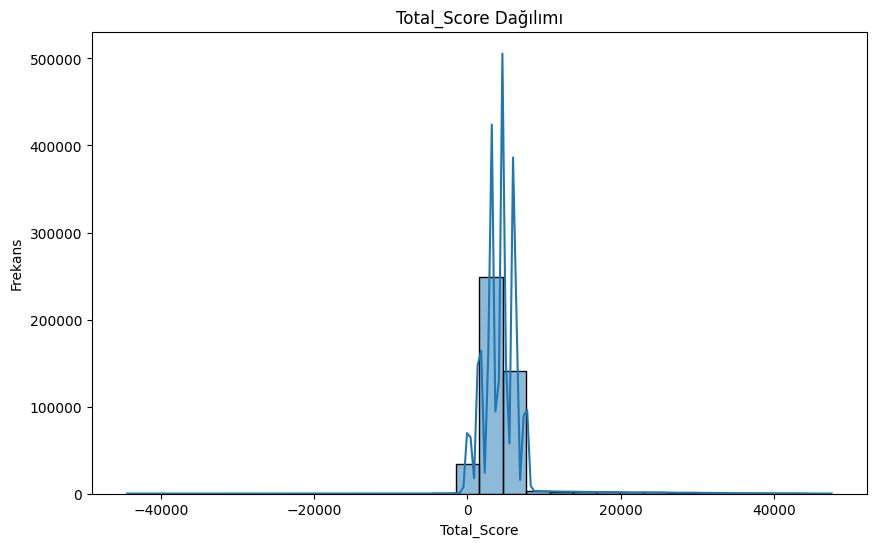

In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['Total_Score'], bins=30, kde=True)
plt.title('Total_Score Dağılımı')
plt.xlabel('Total_Score')
plt.ylabel('Frekans')
plt.show()

In [42]:
# Scale CREDIT_SCORE values ​​between 0 and 1900 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1900))
merged_df['Total_Score_SCALED'] = (scaler.fit_transform(merged_df[['Total_Score']])).astype(int)

In [43]:
merged_df['Total_Score_SCALED'].describe()

,Total_Score_SCALED
count,438510.000000
mean,1013.447370
std,74.751366
min,0.000000
25%,981.000000
50%,1012.000000
75%,1043.000000
max,1900.000000


In [44]:
# Define categories
bins = [-1, 1, 699, 1099, 1499, 1699, 1900]
labels = ['High risk', 'Risky', 'Medium risk', 'Normal', 'Good', 'Very good']

# Apply categories
merged_df['Total_Score_CATEGORY'] = pd.cut(merged_df['Total_Score_SCALED'], bins=bins, labels=labels)

# Check the results
print(merged_df[['Total_Score', 'Total_Score_SCALED', 'Total_Score_CATEGORY']].head())

   Total_Score  Total_Score_SCALED Total_Score_CATEGORY
0      14910.0                1226               Normal
1      14210.0                1211               Normal
2      10500.0                1134               Normal
3       5800.0                1037          Medium risk
4       5940.0                1040          Medium risk


**Last manupulation for Target_Label**

We are fine-tuning the Medium Risks to ensure an even distribution of the Target Label.

In [45]:
income_labels = ['Low', 'Lower Middle', 'Middle', 'Upper Middle', 'High']

# Classifying the Medium risk category
merged_df['Income_Bin'] = pd.cut(merged_df['AMT_INCOME_TOTAL'], bins=income_bins, labels=income_labels, right=False)

# Assign Income_Bin for Medium risk category
def assign_income_bin(row):
    if row['Total_Score_CATEGORY'] == 'Medium risk':
        return row['Income_Bin']
    return np.nan

merged_df['Income_Bin'] = merged_df.apply(assign_income_bin, axis=1)

In [46]:
merged_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,...,CREDIT_SCORE,AGE,AGE_GROUP,INCOME_GROUP,MONTHS_EMPLOYED,Evaluation_Score,Total_Score,Total_Score_SCALED,Total_Score_CATEGORY,Income_Bin
0,5008804,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,...,12600.0,32,"[30, 40)","[411750, 450000)",149,20300,14910.0,1226,Normal,NaN
1,5008805,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,...,11600.0,32,"[30, 40)","[411750, 450000)",149,20300,14210.0,1211,Normal,NaN
2,5008806,M,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,...,6300.0,58,"[50, 60)","[56250, 261000)",37,20300,10500.0,1134,Normal,NaN
3,5008808,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,...,-200.0,52,"[50, 60)","[261000, 411750)",100,19800,5800.0,1037,Medium risk,Middle
4,5008809,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,...,0.0,52,"[50, 60)","[261000, 411750)",100,19800,5940.0,1040,Medium risk,Middle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438505,6840104,M,N,Y,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,0,...,0.0,62,"[60, 70)","[56250, 261000)",137,10300,3090.0,981,Medium risk,Lower Middle
438506,6840222,F,N,N,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,0,...,0.0,43,"[40, 50)","[56250, 261000)",98,4800,1440.0,947,Medium risk,Lower Middle
438507,6841878,F,N,N,54000.0,Commercial associate,Higher education,Single / not married,With parents,1,...,0.0,22,"[0, 30)","[0, 56250)",12,9800,2940.0,978,Medium risk,Low
438508,6842765,F,N,Y,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,0,...,0.0,59,"[50, 60)","[56250, 261000)",122,10800,3240.0,984,Medium risk,Lower Middle


In [47]:
# Define the probabilities
medium_risk_probabilities = {
    'Low': 0,
    'Lower Middle': [0.35, 0.65],
    'Middle': [0.5, 0.5],  # Assuming equal probability for 1 and 0
    'Upper Middle': [0.5, 0.5],  # Assuming equal probability for 1 and 0
    'High': 1
}

probabilities = {
    'Very good': 1,
    'Good': 1,
    'Normal': [0.6, 0.4],
    'Risky': 0,
    'High risk': 0
}

# Function to handle Medium risk probabilities
def get_medium_risk_label(income_bin):
    if income_bin in medium_risk_probabilities:
        prob = medium_risk_probabilities[income_bin]
        if isinstance(prob, list):
            return np.random.choice([1, 0], p=prob)
        return prob
    return np.nan

# Function to handle other probabilities
def get_other_label(category):
    if category in probabilities:
        prob = probabilities[category]
        if isinstance(prob, list):
            return np.random.choice([1, 0], p=prob)
        return prob
    return np.nan

# Apply the vectorized operations
merged_df['TARGET_LABEL'] = np.where(
    merged_df['Total_Score_CATEGORY'] == 'Medium risk',
    merged_df['Income_Bin'].apply(get_medium_risk_label),
    merged_df['Total_Score_CATEGORY'].apply(get_other_label)
)

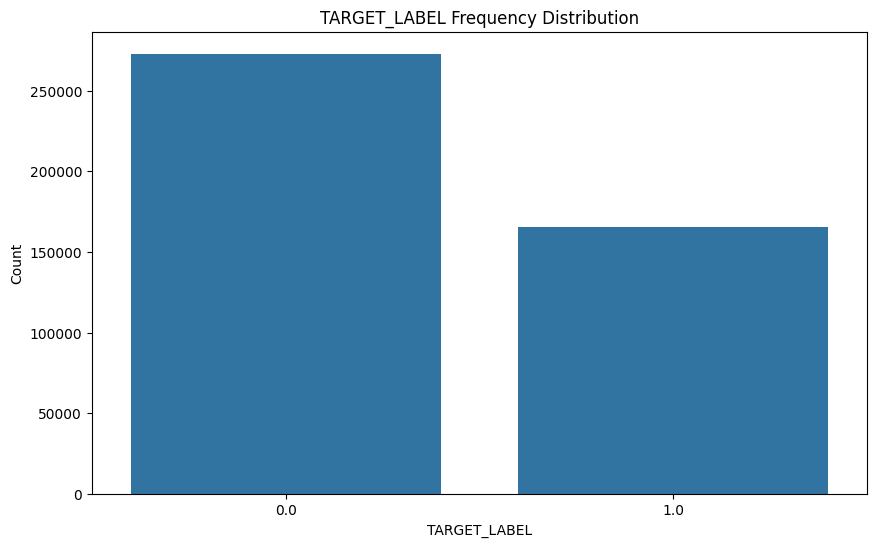

In [48]:
# Visualize TARGET_LABEL distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='TARGET_LABEL', data=merged_df)
plt.title('TARGET_LABEL Frequency Distribution')
plt.xlabel('TARGET_LABEL')
plt.ylabel('Count')
plt.show()

As seen in the graph, we have obtained a distribution close to what we wanted.

Now we will visualize and interpret our data.

<a id="7"></a>
## 7. Data Visualization

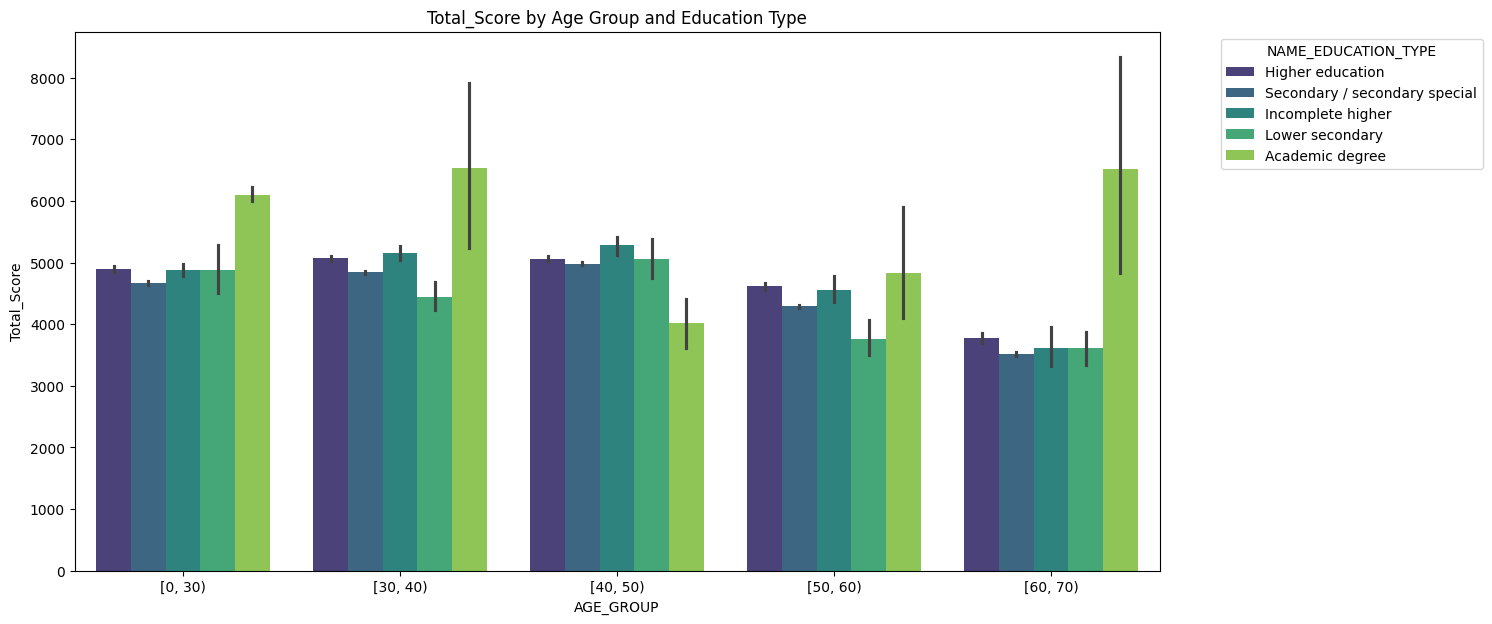

In [49]:
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_df, x='AGE_GROUP', y='Total_Score', hue='NAME_EDUCATION_TYPE', palette='viridis')
plt.title('Total_Score by Age Group and Education Type')
plt.xlabel('AGE_GROUP')
plt.ylabel('Total_Score')
plt.legend(title='NAME_EDUCATION_TYPE', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Observation

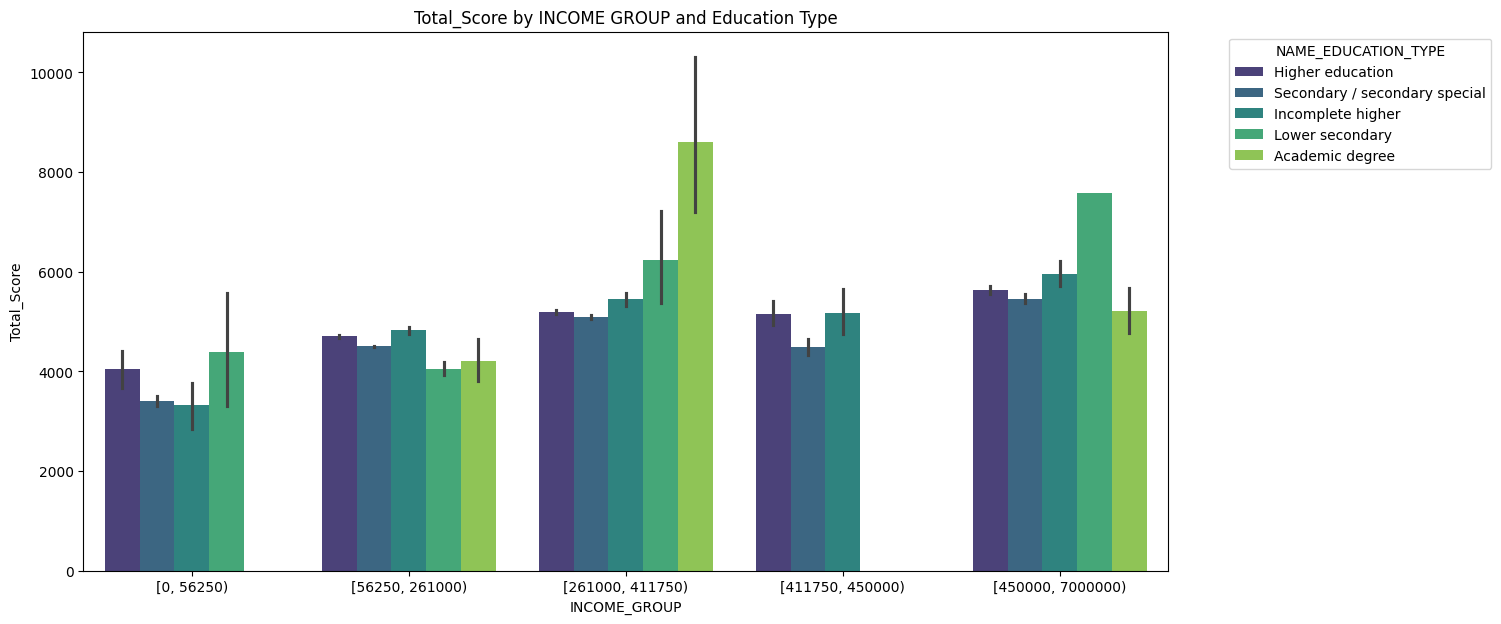

In [50]:
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_df, x='INCOME_GROUP', y='Total_Score', hue='NAME_EDUCATION_TYPE', palette='viridis')
plt.title('Total_Score by INCOME GROUP and Education Type')
plt.xlabel('INCOME_GROUP')
plt.ylabel('Total_Score')
plt.legend(title='NAME_EDUCATION_TYPE', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Gözlemler:


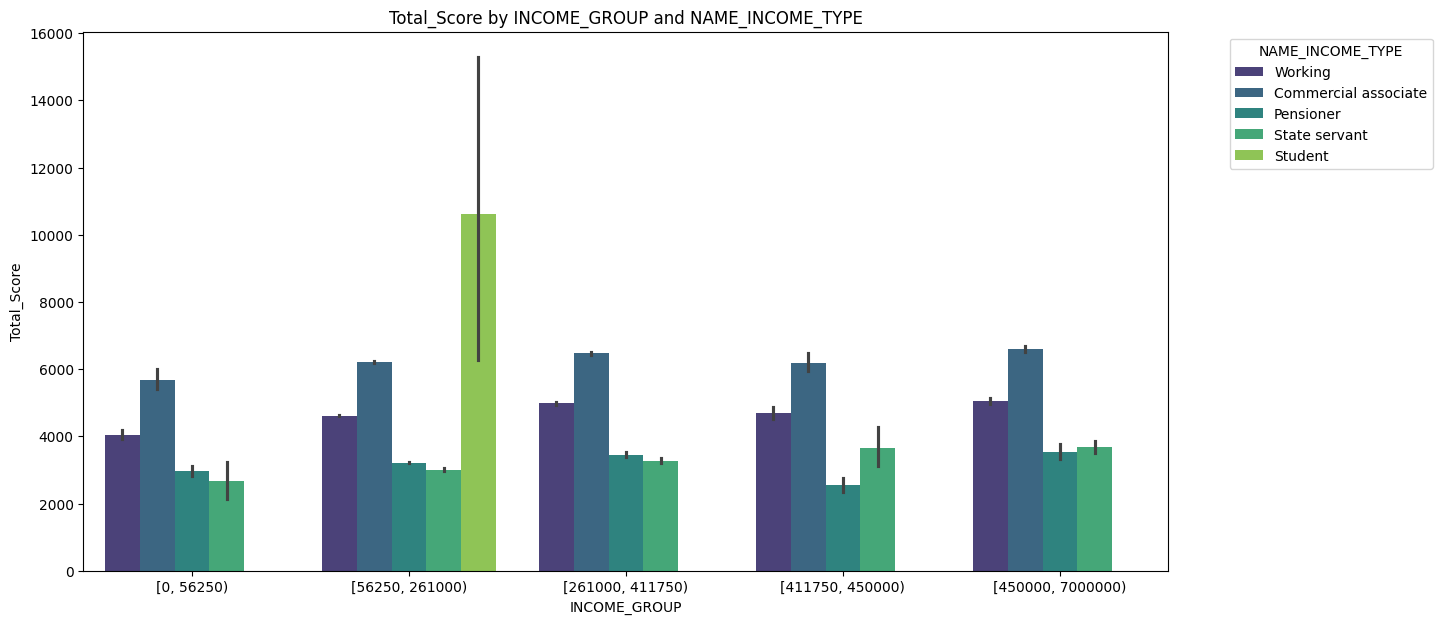

In [51]:
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_df, x='INCOME_GROUP', y='Total_Score', hue='NAME_INCOME_TYPE', palette='viridis')
plt.title('Total_Score by INCOME_GROUP and NAME_INCOME_TYPE')
plt.xlabel('INCOME_GROUP')
plt.ylabel('Total_Score')
plt.legend(title='NAME_INCOME_TYPE', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Gözlemler:


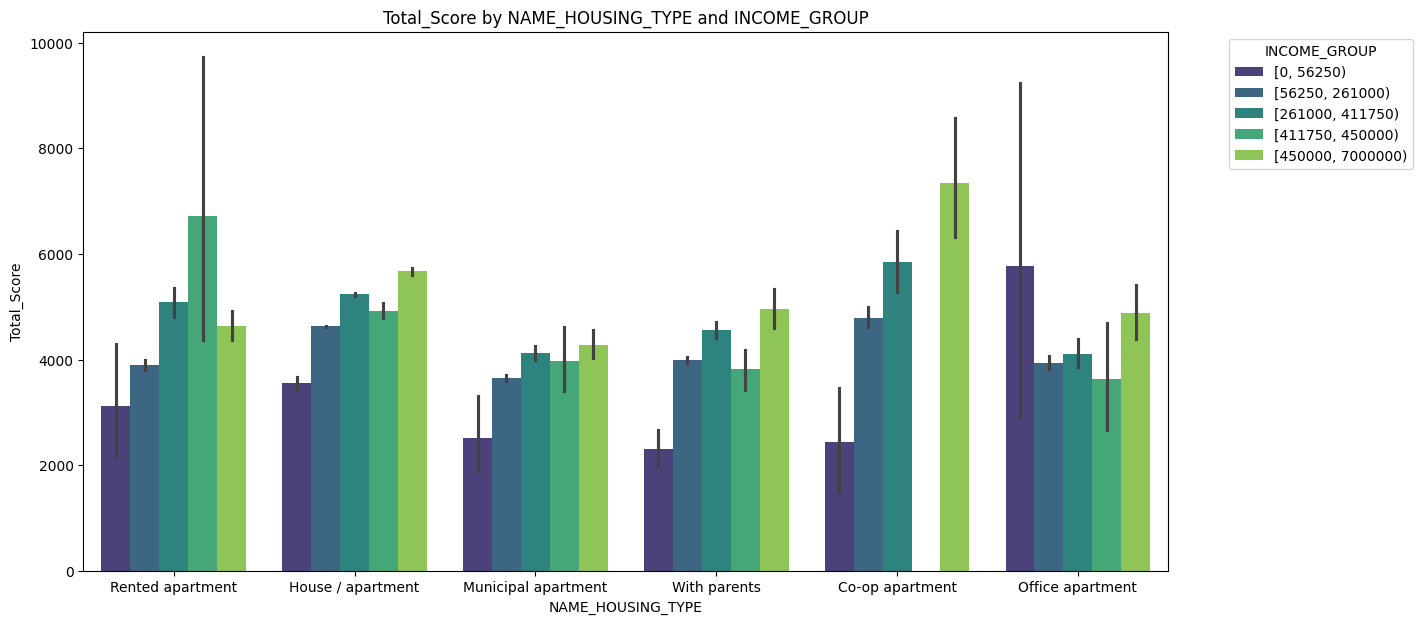

In [52]:
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_df, x='NAME_HOUSING_TYPE', y='Total_Score', hue='INCOME_GROUP', palette='viridis')
plt.title('Total_Score by NAME_HOUSING_TYPE and INCOME_GROUP')
plt.xlabel('NAME_HOUSING_TYPE')
plt.ylabel('Total_Score')
plt.legend(title='INCOME_GROUP', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Gözlemler:


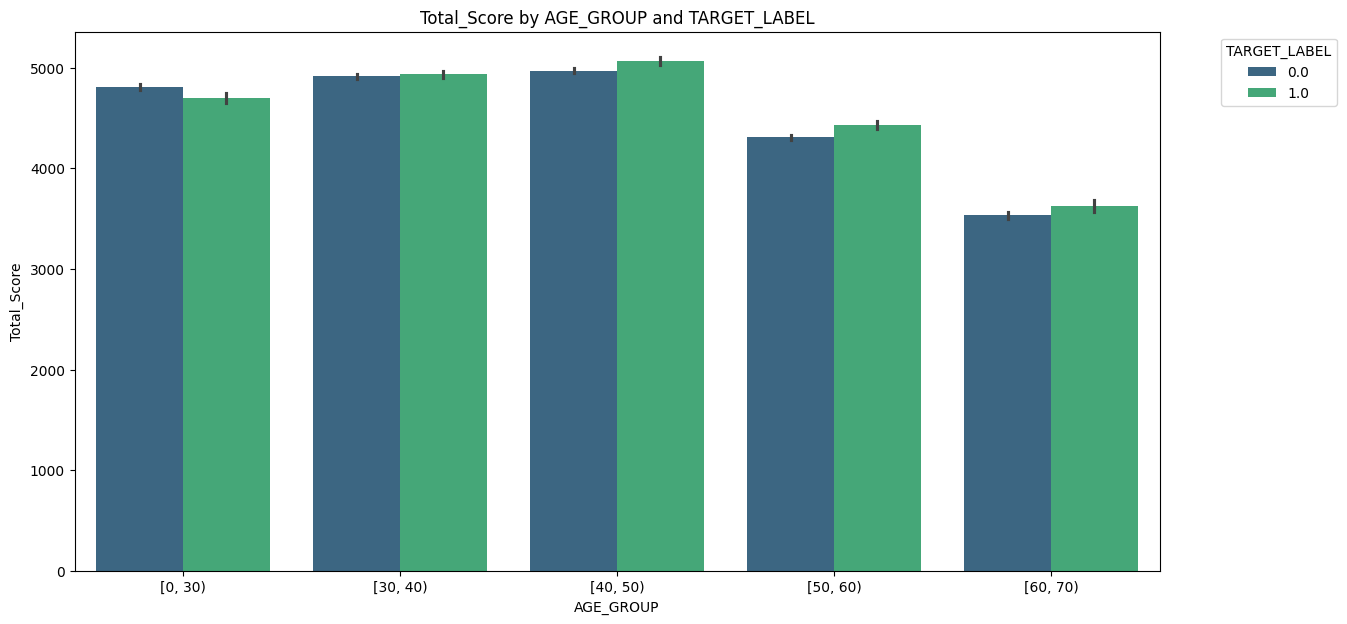

In [53]:
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_df, x='AGE_GROUP', y='Total_Score', hue='TARGET_LABEL', palette='viridis')
plt.title('Total_Score by AGE_GROUP and TARGET_LABEL')
plt.xlabel('AGE_GROUP')
plt.ylabel('Total_Score')
plt.legend(title='TARGET_LABEL', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

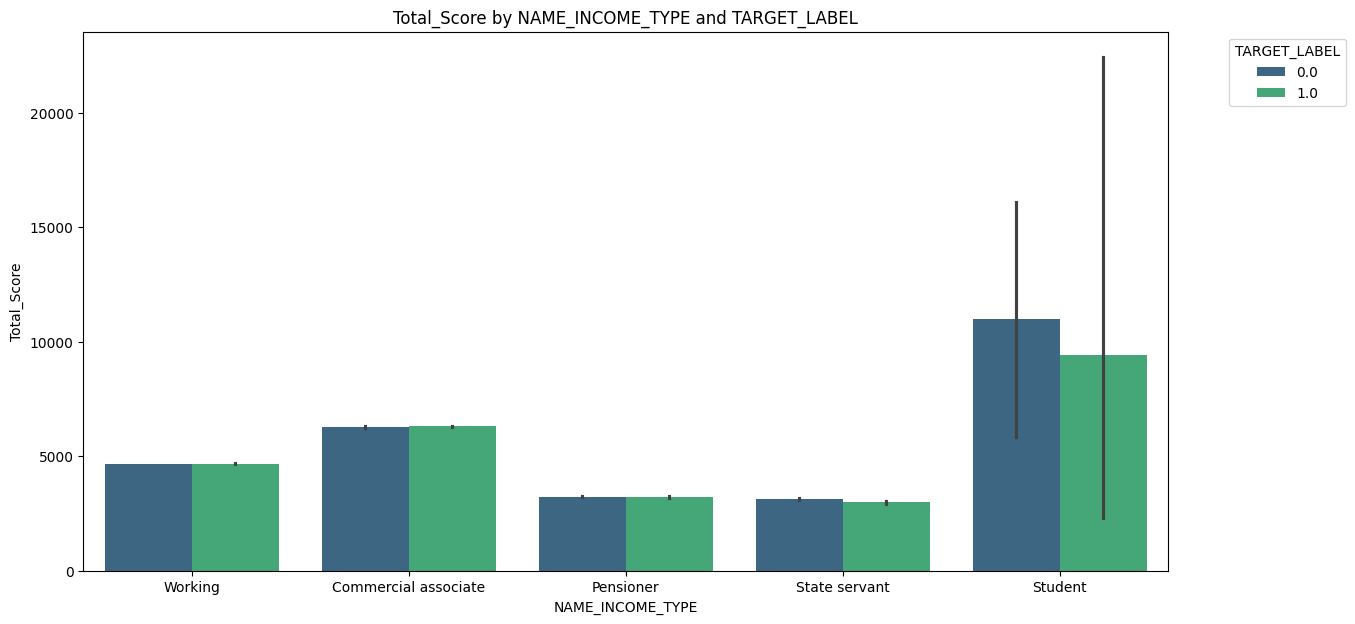

In [54]:
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_df, x='NAME_INCOME_TYPE', y='Total_Score', hue='TARGET_LABEL', palette='viridis')
plt.title('Total_Score by NAME_INCOME_TYPE and TARGET_LABEL')
plt.xlabel('NAME_INCOME_TYPE')
plt.ylabel('Total_Score')
plt.legend(title='TARGET_LABEL', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

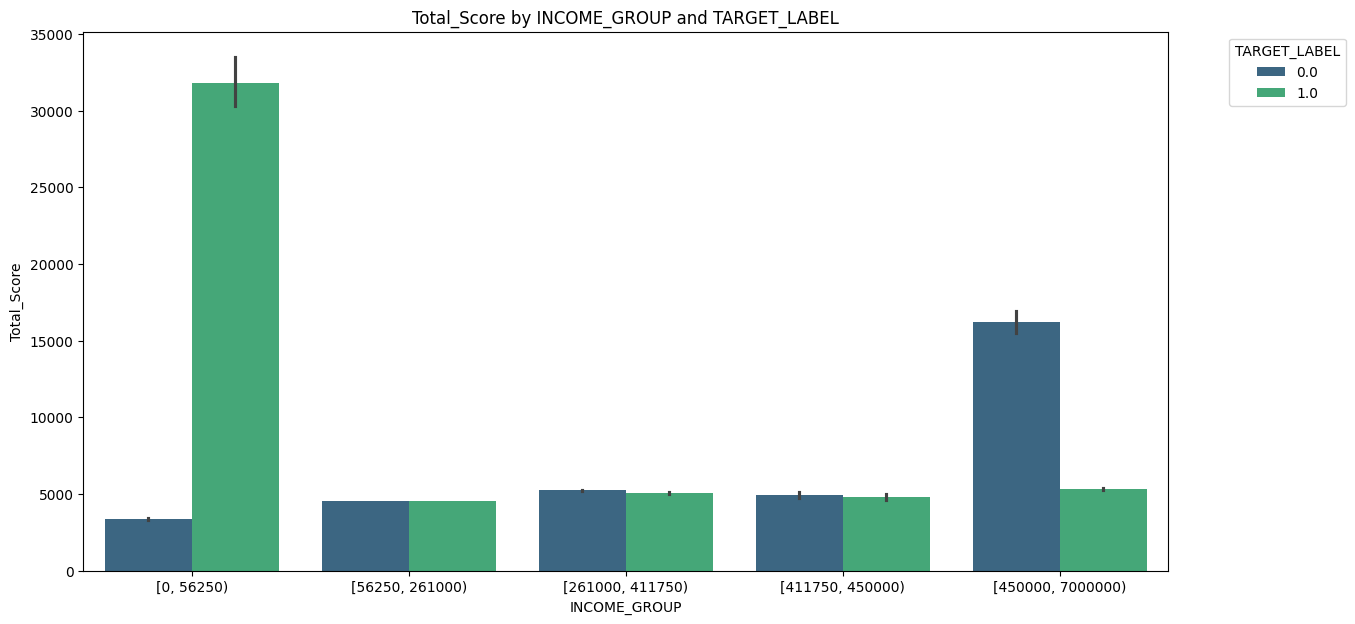

In [55]:
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_df, x='INCOME_GROUP', y='Total_Score', hue='TARGET_LABEL', palette='viridis')
plt.title('Total_Score by INCOME_GROUP and TARGET_LABEL')
plt.xlabel('INCOME_GROUP')
plt.ylabel('Total_Score')
plt.legend(title='TARGET_LABEL', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

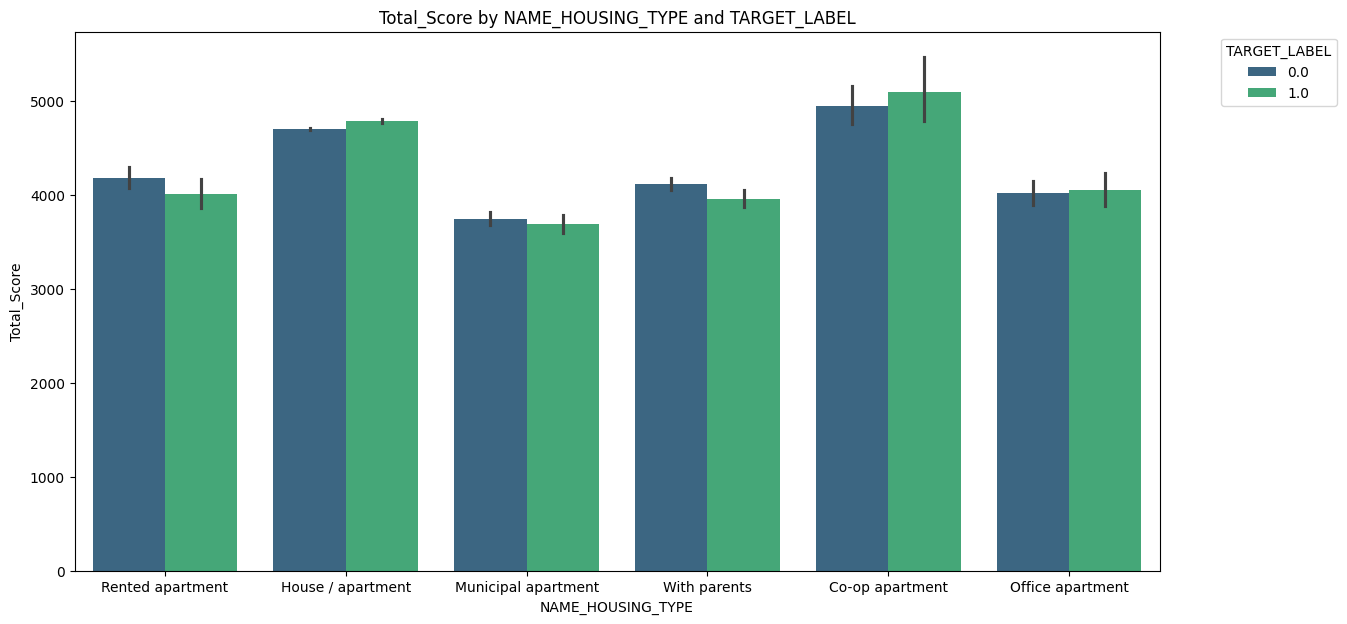

In [56]:
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_df, x='NAME_HOUSING_TYPE', y='Total_Score', hue='TARGET_LABEL', palette='viridis')
plt.title('Total_Score by NAME_HOUSING_TYPE and TARGET_LABEL')
plt.xlabel('NAME_HOUSING_TYPE')
plt.ylabel('Total_Score')
plt.legend(title='TARGET_LABEL', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<a id="8"></a>
## 8. Data Preprocessing and Splitting

In [57]:
merged_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,...,AGE,AGE_GROUP,INCOME_GROUP,MONTHS_EMPLOYED,Evaluation_Score,Total_Score,Total_Score_SCALED,Total_Score_CATEGORY,Income_Bin,TARGET_LABEL
0,5008804,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,...,32,"[30, 40)","[411750, 450000)",149,20300,14910.0,1226,Normal,NaN,0.0
1,5008805,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,...,32,"[30, 40)","[411750, 450000)",149,20300,14210.0,1211,Normal,NaN,0.0
2,5008806,M,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,...,58,"[50, 60)","[56250, 261000)",37,20300,10500.0,1134,Normal,NaN,0.0
3,5008808,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,...,52,"[50, 60)","[261000, 411750)",100,19800,5800.0,1037,Medium risk,Middle,1.0
4,5008809,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,...,52,"[50, 60)","[261000, 411750)",100,19800,5940.0,1040,Medium risk,Middle,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438505,6840104,M,N,Y,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,0,...,62,"[60, 70)","[56250, 261000)",137,10300,3090.0,981,Medium risk,Lower Middle,0.0
438506,6840222,F,N,N,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,0,...,43,"[40, 50)","[56250, 261000)",98,4800,1440.0,947,Medium risk,Lower Middle,1.0
438507,6841878,F,N,N,54000.0,Commercial associate,Higher education,Single / not married,With parents,1,...,22,"[0, 30)","[0, 56250)",12,9800,2940.0,978,Medium risk,Low,0.0
438508,6842765,F,N,Y,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,0,...,59,"[50, 60)","[56250, 261000)",122,10800,3240.0,984,Medium risk,Lower Middle,0.0


In [58]:
merged_df.drop('ID', axis=1, inplace=True)

In [59]:
# Drop specified columns and set target variable
y = merged_df['TARGET_LABEL']

columns_to_drop = ['AGE_GROUP', 'INCOME_GROUP', 'Evaluation_Score', 'Total_Score',
                   'Total_Score_SCALED', 'Total_Score_CATEGORY', 'Income_Bin', 'TARGET_LABEL']
X = merged_df.drop(columns=columns_to_drop)

Identify column types

In [60]:
categorical_columns = X.select_dtypes(include=['object']).columns
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns

Create preprocessing pipelines

In [61]:
def process_categorical(df, column):
    unique_values = df[column].unique()

    if len(unique_values) == 2:
        # İkili değişkenler için tek sütun oluştur
        return pd.DataFrame({column: (df[column] == unique_values[0]).astype(int)})
    else:
        # Çok kategorili değişkenler için one-hot encoding uygula
        dummies = pd.get_dummies(df[column], prefix=column, dtype=int)

        # Sütun adlarını orijinal formata dönüştür
        new_column_names = {col: f"{column}_{val}" for col, val in
                            zip(dummies.columns, unique_values)}
        dummies.rename(columns=new_column_names, inplace=True)

        return dummies

In [62]:
# Kategorik değişkenleri işle
categorical_encoded = pd.concat([process_categorical(X, col) for col in categorical_columns], axis=1)

In [63]:
categorical_encoded

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,...,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_IT staff
0,1,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1,1,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
2,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438505,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
438506,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
438507,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
438508,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Fit and transform the data

In [64]:
# Sayısal değişkenleri normalize et
scaler = StandardScaler()
numeric_normalized = pd.DataFrame(scaler.fit_transform(X[numeric_columns]),
                                  columns=numeric_columns,
                                  index=X.index)

categorical_normalized = pd.DataFrame(scaler.fit_transform(categorical_encoded[categorical_encoded.columns]),
                                      columns=categorical_encoded.columns,
                                      index=X.index)
# İşlenmiş verileri birleştir
processed_features = pd.concat([categorical_normalized, numeric_normalized], axis=1)

In [65]:
processed_features

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,...,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_IT staff,AMT_INCOME_TOTAL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_ADLT_FAM_MEMBERS,CREDIT_SCORE,AGE,MONTHS_EMPLOYED
0,1.429384,1.299574,0.665029,-0.546119,-0.455990,-0.299895,-0.006226,0.969311,-0.026683,1.652790,...,1.505956,-0.061737,2.180031,1.962448,-0.635631,-0.348326,0.550545,2.705900,-0.985666,0.758871
1,1.429384,1.299574,0.665029,-0.546119,-0.455990,-0.299895,-0.006226,0.969311,-0.026683,1.652790,...,1.505956,-0.061737,2.180031,1.962448,-0.635631,-0.348326,0.550545,2.479044,-0.985666,0.758871
2,1.429384,1.299574,0.665029,-0.546119,-0.455990,-0.299895,-0.006226,0.969311,-0.026683,-0.605038,...,-0.664030,-0.061737,-0.681509,-0.509568,-0.635631,-0.348326,0.550545,1.276705,1.283177,-0.759059
3,-0.699602,-0.769483,0.665029,1.831101,-0.455990,-0.299895,-0.006226,-1.031661,-0.026683,-0.605038,...,-0.664030,-0.061737,0.749261,-0.509568,1.573239,2.870872,-1.816382,-0.197862,0.759598,0.094776
4,-0.699602,-0.769483,0.665029,1.831101,-0.455990,-0.299895,-0.006226,-1.031661,-0.026683,-0.605038,...,-0.664030,-0.061737,0.749261,-0.509568,1.573239,2.870872,-1.816382,-0.152491,0.759598,0.094776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438505,1.429384,-0.769483,0.665029,-0.546119,2.193032,-0.299895,-0.006226,-1.031661,-0.026683,-0.605038,...,1.505956,-0.061737,-0.477113,-0.509568,-0.635631,-0.348326,-1.816382,-0.152491,1.632230,0.596235
438506,-0.699602,-0.769483,-1.503695,-0.546119,-0.455990,-0.299895,-0.006226,0.969311,-0.026683,-0.605038,...,-0.664030,-0.061737,-0.763267,-0.509568,-0.635631,-0.348326,-1.816382,-0.152491,-0.025771,0.067670
438507,-0.699602,-0.769483,-1.503695,1.831101,-0.455990,-0.299895,-0.006226,-1.031661,-0.026683,1.652790,...,-0.664030,-0.061737,-1.212937,1.962448,-0.635631,-0.348326,-1.816382,-0.152491,-1.858299,-1.097883
438508,-0.699602,-0.769483,0.665029,-0.546119,2.193032,-0.299895,-0.006226,-1.031661,-0.026683,-0.605038,...,1.505956,-0.061737,-1.049421,-0.509568,-0.635631,-0.348326,0.550545,-0.152491,1.370440,0.392941


Split the data

In [66]:
X_train, X_test, y_train, y_test = train_test_split(processed_features, y, test_size=0.2, random_state=42)

<a id="9"></a>
## 9. Model Training and Evaluation

### Model Selection

In [67]:
from sklearn.base import clone
from joblib import Parallel, delayed

In [68]:
def evaluate_model(model, name, X_train, y_train, X_test, y_test):
    """Evaluate a single model"""
    model = clone(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    return name, model, accuracy, report

def train_evaluate_model(models, X_train, y_train, X_test, y_test, n_jobs=-1):
    """
    Train and evaluate multiple models in parallel.

    Parameters:
    models (dict): A dictionary of model names and their corresponding instances.
    X_train (array-like): Training features.
    y_train (array-like): Training labels.
    X_test (array-like): Test features.
    y_test (array-like): Test labels.
    n_jobs (int): Number of jobs to run in parallel. -1 means using all processors.

    Returns:
    dict: A dictionary containing evaluation results for each model.
    """
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_model)(model, name, X_train, y_train, X_test, y_test)
        for name, model in models.items()
    )

    results_dict = {}
    for name, model, accuracy, report in results:
        results_dict[name] = {
            'model': model,
            'accuracy': accuracy,
            'classification_report': report
        }
        print(f"\n{name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print("Classification Report:")
        print(classification_report(y_test, model.predict(X_test)))

    return results_dict

In [71]:
# Create a dictionary of models
models = {
    'Linear SVC': LinearSVC(random_state=42),
    'Naive Bayes': GaussianNB(),
    'KNeighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Light GBM': lgb.LGBMClassifier(random_state=42),
    'XGB Classifier': xgb.XGBClassifier(random_state=42),
}

results = train_evaluate_model(models, X_train, y_train, X_test, y_test)


Linear SVC Results:
Accuracy: 0.6442
Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.94      0.77     54585
         1.0       0.62      0.15      0.24     33117

    accuracy                           0.64     87702
   macro avg       0.63      0.55      0.50     87702
weighted avg       0.64      0.64      0.57     87702


Naive Bayes Results:
Accuracy: 0.6073
Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.81      0.72     54585
         1.0       0.47      0.28      0.35     33117

    accuracy                           0.61     87702
   macro avg       0.56      0.54      0.53     87702
weighted avg       0.58      0.61      0.58     87702


KNeighbors Results:
Accuracy: 0.5925
Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.75      0.70     54585
         1.0       0.45      0.34      0.38     33117

### Calculating Class Weights for an Imbalanced Dataset

To improve the performance of our classification models and address the class imbalance in the dataset, we will calculate the weights for each class. This will give more importance to the minority class, allowing the model to learn more balanced.

In [72]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Class Weights:", class_weight_dict)

Class Weights: {0.0: 0.8031281908049872, 1.0: 1.3247335865928538}


In [73]:
# Update models
models = {
    'Light GBM': lgb.LGBMClassifier(class_weight=class_weight_dict),
    'XGB Classifier': xgb.XGBClassifier(scale_pos_weight=class_weight_dict[1]/class_weight_dict[0]),
}

results = train_evaluate_model(models, X_train, y_train, X_test, y_test)


Light GBM Results:
Accuracy: 0.6515
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.88      0.76     54585
         1.0       0.58      0.28      0.38     33117

    accuracy                           0.65     87702
   macro avg       0.62      0.58      0.57     87702
weighted avg       0.63      0.65      0.61     87702


XGB Classifier Results:
Accuracy: 0.6307
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.81      0.73     54585
         1.0       0.52      0.33      0.40     33117

    accuracy                           0.63     87702
   macro avg       0.59      0.57      0.57     87702
weighted avg       0.61      0.63      0.61     87702



<a id="10"></a>
## 10. Future Extraction and Importance

In [74]:
print("Number of features:", X.shape[1])
print("\nFeature names:")
print(X.columns.tolist())

print("\nNumerical features:")
print(numeric_columns.tolist())
print("\nCategorical features:")
print(categorical_columns.tolist())

# Display statistics of numeric features
print("\nNumerical features:")
print(X[numeric_columns].describe())

# Display unique values ​​of categorical features
print("\nUnique values ​​of categorical features:")
for feature in categorical_columns:
  print(f"{feature}: {X[feature].nunique()}")

Number of features: 16

Feature names:
['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_ADLT_FAM_MEMBERS', 'CREDIT_SCORE', 'AGE', 'MONTHS_EMPLOYED']

Numerical features:
['AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_ADLT_FAM_MEMBERS', 'CREDIT_SCORE', 'AGE', 'MONTHS_EMPLOYED']

Categorical features:
['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']

Numerical features:
       AMT_INCOME_TOTAL  FLAG_WORK_PHONE     FLAG_PHONE     FLAG_EMAIL  \
count      4.385100e+05    438510.000000  438510.000000  438510.000000   
mean       1.875209e+05         0.206134       0.287763       0.108203   
std        1.100807e+05         0.404529       0.452721       0.310637   
min        2.610000e+

In [75]:
# Let's create new features
X['INCOME_AGE_RATIO'] = X['AMT_INCOME_TOTAL'] / X['AGE']
X['EMPLOYMENT_RATIO'] = X['MONTHS_EMPLOYED'] / (X['AGE'] * 12)

In [76]:
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
numeric_columns

Index(['AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_ADLT_FAM_MEMBERS', 'CREDIT_SCORE', 'AGE', 'MONTHS_EMPLOYED',
       'INCOME_AGE_RATIO', 'EMPLOYMENT_RATIO'],
      dtype='object')

In [77]:
# Kategorik değişkenleri işle
categorical_encoded = pd.concat([process_categorical(X, col) for col in categorical_columns], axis=1)
# Sayısal değişkenleri normalize et
scaler = StandardScaler()
numeric_normalized = pd.DataFrame(scaler.fit_transform(X[numeric_columns]),
                                  columns=numeric_columns,
                                  index=X.index)

categorical_normalized = pd.DataFrame(scaler.fit_transform(categorical_encoded[categorical_encoded.columns]),
                                      columns=categorical_encoded.columns,
                                      index=X.index)
# İşlenmiş verileri birleştir
processed_features = pd.concat([categorical_normalized, numeric_normalized], axis=1)
X_train, X_test, y_train, y_test = train_test_split(processed_features, y, test_size=0.2, random_state=42)

In [78]:
models = {
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Light GBM': lgb.LGBMClassifier(class_weight=class_weight_dict),
    'XGB Classifier': xgb.XGBClassifier(scale_pos_weight=class_weight_dict[1]/class_weight_dict[0])
}

In [79]:
results = train_evaluate_model(models, X_train, y_train, X_test, y_test)


Gradient Boosting Results:
Accuracy: 0.6526
Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.97      0.78     54585
         1.0       0.73      0.13      0.22     33117

    accuracy                           0.65     87702
   macro avg       0.69      0.55      0.50     87702
weighted avg       0.68      0.65      0.57     87702


Light GBM Results:
Accuracy: 0.6512
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.88      0.76     54585
         1.0       0.58      0.28      0.38     33117

    accuracy                           0.65     87702
   macro avg       0.62      0.58      0.57     87702
weighted avg       0.63      0.65      0.61     87702


XGB Classifier Results:
Accuracy: 0.6281
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.81      0.73     54585
         1.0       0.51      0.33      0.40 

In [80]:
# Calculating feature importance levels with Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [81]:
# Display feature importance levels
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("The 20 most important features:")
print(feature_importance.head(20))

The 20 most important features:
                                  feature  importance
43                       AMT_INCOME_TOTAL    0.167351
51                       INCOME_AGE_RATIO    0.160206
52                       EMPLOYMENT_RATIO    0.122870
50                        MONTHS_EMPLOYED    0.106596
48                           CREDIT_SCORE    0.099677
49                                    AGE    0.097092
45                             FLAG_PHONE    0.019118
2                         FLAG_OWN_REALTY    0.019089
1                            FLAG_OWN_CAR    0.013498
0                             CODE_GENDER    0.013226
44                        FLAG_WORK_PHONE    0.011476
46                             FLAG_EMAIL    0.009326
14             NAME_FAMILY_STATUS_Married    0.008982
32  OCCUPATION_TYPE_High skill tech staff    0.008689
41          OCCUPATION_TYPE_Realty agents    0.007691
7                NAME_INCOME_TYPE_Student    0.007463
47                   CNT_ADLT_FAM_MEMBERS    0.007

In [82]:
# Selecting the most important features (e.g. until the total importance exceeds 0.95)
cumulative_importance = 0
important_features = []
for idx, row in feature_importance.iterrows():
    important_features.append(row['feature'])
    cumulative_importance += row['importance']
    if cumulative_importance > 0.95:
        break

print(f"\nNumber of selected features: {len(important_features)}")
print("Selected features:")
print(important_features)


Number of selected features: 29
Selected features:
['AMT_INCOME_TOTAL', 'INCOME_AGE_RATIO', 'EMPLOYMENT_RATIO', 'MONTHS_EMPLOYED', 'CREDIT_SCORE', 'AGE', 'FLAG_PHONE', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR', 'CODE_GENDER', 'FLAG_WORK_PHONE', 'FLAG_EMAIL', 'NAME_FAMILY_STATUS_Married', 'OCCUPATION_TYPE_High skill tech staff', 'OCCUPATION_TYPE_Realty agents', 'NAME_INCOME_TYPE_Student', 'CNT_ADLT_FAM_MEMBERS', 'NAME_HOUSING_TYPE_House / apartment', 'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Separated', 'NAME_INCOME_TYPE_Working', 'OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_Secretaries', 'OCCUPATION_TYPE_Private service staff', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_INCOME_TYPE_Pensioner', 'NAME_FAMILY_STATUS_Single / not married', 'OCCUPATION_TYPE_Laborers']


In [83]:
# Creating new datasets with selected features
X_train_selected = X_train[important_features]
X_test_selected = X_test[important_features]

results = train_evaluate_model(models, X_train_selected, y_train, X_test_selected, y_test)


Gradient Boosting Results:
Accuracy: 0.6528
Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.97      0.78     54585
         1.0       0.73      0.13      0.22     33117

    accuracy                           0.65     87702
   macro avg       0.69      0.55      0.50     87702
weighted avg       0.68      0.65      0.56     87702


Light GBM Results:
Accuracy: 0.6509
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.88      0.76     54585
         1.0       0.58      0.28      0.37     33117

    accuracy                           0.65     87702
   macro avg       0.62      0.58      0.57     87702
weighted avg       0.63      0.65      0.61     87702


XGB Classifier Results:
Accuracy: 0.6306
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.81      0.73     54585
         1.0       0.52      0.34      0.41 

<a id="11"></a>
## 11. Hyperparameter Tuning and Optimization for LightGBM ve Gradient Boosting

In [96]:
from joblib import parallel_backend
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import make_scorer, log_loss

In [107]:
X_train, X_test, y_train, y_test = train_test_split(processed_features, y, test_size=0.2, random_state=42)

In [108]:
models = {
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Light GBM': lgb.LGBMClassifier(
        class_weight=class_weight_dict,
        random_state=42,
        n_jobs=-1,  # Use all CPU cores
        importance_type='gain'  # For better feature importance
    ),
    'XGB Classifier': xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=class_weight_dict[1]/class_weight_dict[0],
    enable_categorical=True  # Kategorik özellikleri otomatik işlemek için
    )
}

In [109]:
def train_evaluate_with_hyperopt(models, param_dists, X_train, y_train, X_test, y_test, n_iter=30, cv=3, n_jobs=-1):
    """
    Train and evaluate models with hyperparameter optimization.

    Parameters:
    models (dict): A dictionary of model names and their corresponding instances.
    param_dists (dict): A dictionary of hyperparameter distributions for each model.
    X_train (array-like): Training features.
    y_train (array-like): Training labels.
    X_test (array-like): Test features.
    y_test (array-like): Test labels.
    n_iter (int): Number of parameter settings sampled in RandomizedSearchCV.
    cv (int): Number of cross-validation folds.
    n_jobs (int): Number of jobs to run in parallel.

    Returns:
    dict: A dictionary containing evaluation results and best models for each model type.
    """
    results = {}
    best_models = {}

    # Use F1 score as the scoring metric
    f1_scorer = make_scorer(f1_score, average='weighted')

    for name, model in models.items():
        print(f"\nOptimizing {name}...")

        with parallel_backend('threading', n_jobs=n_jobs):
            random_search = RandomizedSearchCV(
                model,
                param_distributions=param_dists[name],
                n_iter=n_iter,
                cv=cv,
                scoring=f1_scorer,
                n_jobs=1,  # Use 1 here because we're using parallel_backend
                random_state=42
            )

            random_search.fit(X_train, y_train)

        best_model = random_search.best_estimator_
        best_models[name] = best_model

        y_pred = best_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        report = classification_report(y_test, y_pred, output_dict=True)

        results[name] = {
            'best_model': best_model,
            'best_params': random_search.best_params_,
            'accuracy': accuracy,
            'f1_score': f1,
            'classification_report': report
        }

        print(f"\n{name} Results:")
        print(f"Best Parameters: {random_search.best_params_}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

    return results, best_models

In [113]:
# Hiperparametre dağılımları
gb_param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

lgbm_param_dist = {
    'n_estimators': [100, 200],
    'num_leaves': [31, 6],  # Larger values for better accuracy, but not too large
    'max_depth': [5, 7],  # Limit depth to prevent overfitting
    'learning_rate': [0.05, 0.1],  # Smaller learning rates
    'feature_fraction': [0.8, 0.9],  # Feature subsampling to prevent overfitting
    'min_child_samples': [20, 50],  # Prevent overfitting on small leaves
    'lambda_l1': [0, 1.0],  # L1 regularization
    'lambda_l2': [0, 1.0],  # L2 regularization
    'boosting_type': ['gbdt', 'dart'],  # Try both gbdt and dart
}

xgb_param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

param_dists = {
    'Gradient Boosting': gb_param_dist,
    'Light GBM': lgbm_param_dist,
    'XGB Classifier': xgb_param_dist
}

In [114]:
# Fonksiyonu çağırma
results, best_models = train_evaluate_with_hyperopt(models, param_dists, X_train, y_train, X_test, y_test)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [115]:
# En iyi modelleri al
best_lgbm = best_models.get('Light GBM')
best_gb = best_models.get('Gradient Boosting')
best_xgb = best_models.get('XGB Classifier')

<a id="12"></a>
## 12. Ensemble Methods

In [118]:
# Weighted Voting
voting_clf = VotingClassifier(
    estimators=[('lgbm', best_lgbm), ('xgb', best_xgb)],
    voting='soft',
    weights=[1, 1]
)

stacking_clf = StackingClassifier(
    estimators=[('lgbm', best_lgbm), ('xgb', best_xgb)],
    final_estimator=LogisticRegression(),
    cv=5
)

# Compare both ensemble methods
voting_scores = cross_val_score(voting_clf, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
stacking_scores = cross_val_score(stacking_clf, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)

print("Weighted Voting mean F1 score:", voting_scores.mean())
print("Stacking mean F1 score:", stacking_scores.mean())

# Choose and train the best ensemble method
if voting_scores.mean() > stacking_scores.mean():
    best_ensemble = voting_clf
    print("Weighted Voting is better")
else:
    best_ensemble = stacking_clf
    print("Stacking is better")

best_ensemble.fit(X_train, y_train)

Weighted Voting mean F1 score: 0.6116464981089108
Stacking mean F1 score: 0.6111533509320801
Weighted Voting is better
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Info] Number of positive: 132407, number of negative: 218401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing 

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(class_weight={0.0: 0.8031281908049872,
                                                           1.0: 1.3247335865928538},
                                             feature_fraction=0.8,
                                             importance_type='gain',
                                             lambda_l1=0, lambda_l2=0,
                                             learning_rate=0.05, max_depth=7,
                                             n_estimators=200, n_jobs=-1,
                                             random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsa...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None, min_child_weight=3,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft', weights=[1, 1])

In [119]:
# Evaluate the best ensemble on the test set
y_pred = best_ensemble.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\nBest Ensemble F1 Score on Test Set: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0

Best Ensemble F1 Score on Test Set: 0.6135

Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.88      0.76     54585
         1.0       0.59      0.27      0.37     33117

    accuracy                           0.65     87702
   macro avg       0.63      0.58      0.57     87702
weighted avg       0.64      0.65      0.61     87702


Gradient Boosting F1 Score on Test Set: 0.5782
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.95      0.77     54585
         1.0       0.67      0.16      0.26     33117

    accuracy                 

<a id="12"></a>
## 13. Handling Class Imbalance

In [120]:
# Oversampling techniques
oversamplers = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'RandomOverSampler': RandomOverSampler(random_state=42)
}

# Try every oversampling technique
for name, oversampler in oversamplers.items():
    X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

    # En iyi ensemble modelini kullanarak skorları hesapla
    scores = cross_val_score(best_ensemble, X_resampled, y_resampled, cv=5, scoring='f1')

    print(f"{name} mean F1 score: {scores.mean()}")

# En iyi oversampling tekniğini seç
best_oversampler = max(oversamplers.items(), key=lambda x: cross_val_score(best_ensemble, *x[1].fit_resample(X_train, y_train), cv=5, scoring='f1').mean())[1]

# Apply best oversampling technique
X_resampled, y_resampled = best_oversampler.fit_resample(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Info] Number of positive: 174721, number of negative: 174720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.698866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can se

<a id="14"></a>
## 14. Final Model Training and Evaluation

In [121]:
# Train the final model
best_ensemble.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = best_ensemble.predict(X_test)
y_pred_proba = best_ensemble.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("F1 Score:", f1_score(y_test, y_pred))

# Show important features
if hasattr(best_ensemble, 'feature_importances_'):
    feature_importance = best_ensemble.feature_importances_
    feature_names = X_train.columns
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, feature_names[sorted_idx])
    plt.title('Feature Importance')
    plt.show()

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Info] Number of positive: 240290, number of negative: 218401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.722762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can se